# General fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Definition of model

Consider controlled parameter range is [-1,1]

In [2]:
# True functional dependece for data generation (triangle)

def mytrue(x):
    
    tri = x + (x>0.5)*(1-2*x) + (x<-0.5)*(-1-2*x)

    return tri

In [3]:
# Fit model - sum of terms:  1, sin(ax), cos(ax), sin(2ax), cos(2ax) ...

# Basic function (return function values only)

def myfun(x,par):

    # Scaling factor
    
    a = par[0]

    # output array
    
    val = np.zeros(x.size)

    # Constant term
    
    val = par[1]

    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

    return val

In [4]:
# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,par.size))

    # Scaling factor (global)
    
    a = par[0]

    # Constant term (global)
    
    val = par[1]

    der[:,1] = 1
    
    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

        der[:,ip] = np.sin(pw*a*x)
        der[:,ip+1] = np.cos(pw*a*x)
        
        der[:,0] += par[ip]*pw*x*np.cos(pw*a*x)
        der[:,0] -= par[ip+1]*pw*x*np.sin(pw*a*x)
        
    return val,der

### (2) Generate pseudo data to fit

In [5]:
# Considered values of x

xvec = np.linspace(-0.95,0.95,20)

# Measurement precision - assume slow variation with x

svec = np.linspace(0.02,0.03,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (3) Initialize an iterative fit

In [6]:
# Number of function parameters to consider  (must be even!!!)

Nfun = 4

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 3.
parini[1] = 0.
parini[2] = 0.5
parini[3] = 0.

# Initial function vales

fini = myfun(xvec,parini) 

# Initial printout

chi2ini = np.sum((yvec-fini)**2/s2vec)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [3.  0.  0.5 0. ]
  chi^2 =   327.757   chi^2/N = 16.38787 


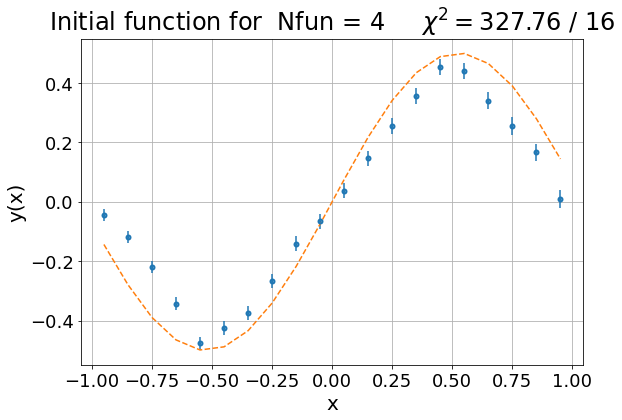

In [7]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fini,'--')

plt.title('Initial function for  Nfun = '+str(Nfun) +'     $\chi^{2} = $'+str(int(100*chi2ini+0.5)/100.)+' / '+str(xvec.size-Nfun),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit1_ini.png'
plt.savefig(fname)

### (4) Iterative fit procedure

In [8]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.00001     # Required precision (distance from minimum)

chi2min = chi2ini
parmin = parini

par = parini

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    dyvec = yvec-fval
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*dyvec/s2vec)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

    # Do not try to jump directly to the maximum (lam = 0)

    C = np.array(A)
    for l in range(Nfun):
        C[l,l] += lam
        
    # Inverse of the matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    chi2new = np.sum((yvec-fnew)**2/s2vec)

    # Estimate the distance to minimum from current step (in units of current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    print("\nIteration step ",Nit," with lambda = ",lam)
    print(" ",parnew)
    print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2new,chi2new/(xvec.size-Nfun)))
    print("  distance to minimum: ",dist)
    
    if chi2new < chi2min :  # Iteration successful, fit got closer to the minimum
        lam /= 10
        chi2min = chi2new
        par = parnew
    else:                   # Iteration failed, reduce step
        lam *= 10



Iteration step  1  with lambda =  0.01
  [ 3.21206042e+00 -5.49874878e-04  4.05820622e-01 -5.86231549e-03]
  chi^2 =    41.268   chi^2/N =  2.57924 
  distance to minimum:  194.87736606618216

Iteration step  2  with lambda =  0.001
  [ 3.25079276e+00 -9.96641482e-04  4.09036083e-01 -5.81851207e-03]
  chi^2 =    39.659   chi^2/N =  2.47867 
  distance to minimum:  1.6531940190400511

Iteration step  3  with lambda =  0.0001
  [ 3.25016859e+00 -9.91012138e-04  4.09098999e-01 -5.85912739e-03]
  chi^2 =    39.658   chi^2/N =  2.47864 
  distance to minimum:  0.0004912117709635443

Iteration step  4  with lambda =  1e-05
  [ 3.25017177e+00 -9.91068776e-04  4.09099175e-01 -5.85847756e-03]
  chi^2 =    39.658   chi^2/N =  2.47864 
  distance to minimum:  1.7899364497588516e-08


In [9]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))



 Fit results:

     par         sigma_p

     3.250  +/-  0.031 
    -0.001  +/-  0.006 
     0.409  +/-  0.008 
    -0.006  +/-  0.008 

 Correlation matrix

[ 1.    -0.157  0.212  0.25 ]
[-0.157  1.     0.135  0.031]
[0.212 0.135 1.    0.006]
[0.25  0.031 0.006 1.   ]

 chi^2 =    39.658   chi^2/Ndf =  2.47864 


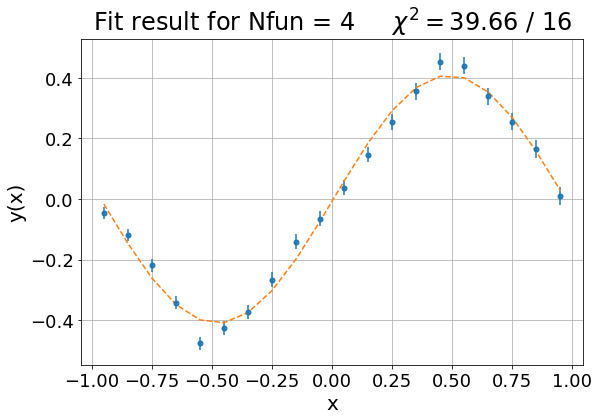

In [10]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fvec,'--')

plt.title('Fit result for Nfun = '+str(Nfun) +'     $\chi^{2} = $'+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit1_'+str(Nfun)+'.png'
plt.savefig(fname)